# Séance 7 : PIG et Paramètres (Azure)

Plan

* [Paramètres](#par)
* [Connexion au cluster](#con)
* [Upload des données](#up)
* [PIG et paramètres](#pig1)
* [Exercice 1 : histograme min,max](#exo1)

<div style="position:absolute; top:10px; right:5px; width:100px; height:90px; margin:10px;">
[Paramètres](#par) -- [Connexion](#con) -- [Upload](#up) -- [PIG et paramètres](#pig1) -- [Exo 1](#exo1)
</div>

<h3 id="par">Paramètres</h3>

Les sites web produisent des données en continu. On utilise fréquemment le même script pour traiter les donnéesd'un jour, du lendemain, de jour d'après... Tous les jours, on veut récupérer la fréquentation de la veille. La seule chose qui change est la date des données qu'on veut traiter. Plutôt que de recopier un script en entier pour changer une date qui apparaît parfois à plusieurs endroits, il est préférable d'écrire un script ou la date apparaît comme une variable.

Ce notebook va illustrer ce procédé sur la construction d'un histogramme. Le paramètre du script sera la largeur des barres de l'histogramme (ou [bin](http://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width) en anglais).

<h3 id="con">Connexion au cluster</h3>

On prend le cluster [Cloudera](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx3/notebooks/td3a_cenonce_session6.html#p2). Il faut exécuter ce script pour pouvoir notifier au notebook que la variable ``params`` existe.

In [1]:
import pyquickhelper, pyensae
params={"blob_storage":"", "password1":"", "hadoop_server":"", "password2":"", "username":"alias"}
pyquickhelper.open_html_form(params=params,title="server + hadoop + credentials", key_save="blobhp")

In [2]:
import pyensae
blobstorage = blobhp["blob_storage"]
blobpassword = blobhp["password1"]
hadoop_server = blobhp["hadoop_server"]
hadoop_password = blobhp["password2"]
username = blobhp["username"]
client, bs =  %hd_open
client, bs

(<pyensae.remote.azure_connection.AzureClient at 0xabaea50>,
 <azure.storage.blobservice.BlobService at 0xabaea90>)

<h3 id="up">Upload version</h3>

On commence par simuler des données.

In [3]:
import random
with open("random.sample.txt", "w") as f :
    for i in range(0,10000) :
        x = random.random()
        f.write(str(x)+"\n")

On uploade le fichier sur le cluster (il n'est pas besoin de créer le répertoire au préalable).

In [6]:
%blob_up random.sample.txt /$PSEUDO/random/random.sample.txt

'$PSEUDO/random/random.sample.txt'

In [9]:
%blob_ls /$PSEUDO/random

,name,last_modified,content_type,content_length,blob_type
0,xavierdupre/random/random.sample.txt,"Thu, 27 Nov 2014 23:21:26 GMT",application/octet-stream,202619,BlockBlob


<h3 id="pig1">PIG et paramètres</h3>

On indique un paramètre par le symbole : ``$bins``. La valeur du paramètre est passé sous forme de chaîne de caractères au script et remplacée telle quelle dans le script. Il en va de même des constantes déclarées grâce au mot-clé [%declare](https://pig.apache.org/docs/r0.11.1/cont.html#Examples-N1060D).

La sortie du script inclut le paramètre : cela permet de retrouver comment ces données ont été générées.

In [11]:
%%PIG histogram.pig

values = LOAD '$CONTAINER/$PSEUDO/random/random.sample.txt' USING PigStorage('\t') AS (x:double);

values_h = FOREACH values GENERATE x, ((int)(x / $bins)) * $bins AS h ;

hist_group = GROUP values_h BY h ;

hist = FOREACH hist_group GENERATE group, COUNT(values_h) AS nb ;

STORE hist INTO '$CONTAINER/$PSEUDO/random/histo_$bins.txt' USING PigStorage('\t') ;

Pour supprimer les précédents résultats :

In [12]:
if client.exists(bs, client.account_name, "$PSEUDO/random/histo_0.1.txt"):
    r = client.delete_folder (bs, client.account_name, "$PSEUDO/random/histo_0.1.txt")
    print(r)    

On exécute le job. Comme la commande magique supportant les paramètres n'existe pas encore, il faut utiliser la variable ``client`` et sa méthode [pig_submit](http://www.xavierdupre.fr/app/pyensae/helpsphinx/pyensae/remote/ssh_remote_connection.html?highlight=pig_submit#pyensae.remote.ssh_remote_connection.ASSHClient.pig_submit) qui fait la même chose. Elle upload le script puis le soumet.

In [14]:
client.pig_submit(bs, client.account_name, "histogram.pig", params = dict(bins="0.1"), stop_on_failure=True )

{'id': 'job_1416874839254_0101'}

In [18]:
st = %hd_job_status job_1416874839254_0101
st["id"],st["percentComplete"],st["status"]["jobComplete"]

('job_1416874839254_0101', '100% complete', True)

In [17]:
%tail_stderr job_1416874839254_0101 10

On vérifie que tout s'est bien passé. La taille devrait être équivalent à l'entrée.

In [19]:
%blob_ls /$PSEUDO/random

,name,last_modified,content_type,content_length,blob_type
0,xavierdupre/random/histo_0.1.txt,"Thu, 27 Nov 2014 23:28:55 GMT",,0,BlockBlob
1,xavierdupre/random/histo_0.1.txt/_SUCCESS,"Thu, 27 Nov 2014 23:28:55 GMT",application/octet-stream,0,BlockBlob
2,xavierdupre/random/histo_0.1.txt/part-r-00000,"Thu, 27 Nov 2014 23:28:54 GMT",application/octet-stream,131,BlockBlob
3,xavierdupre/random/random.sample.txt,"Thu, 27 Nov 2014 23:21:26 GMT",application/octet-stream,202619,BlockBlob


In [21]:
if os.path.exists("histo.txt") : os.remove("histo.txt")
%blob_downmerge /$PSEUDO/random/histo_0.1.txt histo.txt

'histo.txt'

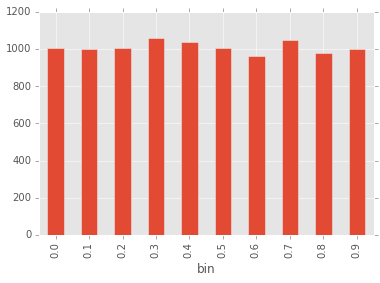

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas
df = pandas.read_csv("histo.txt", sep="\t",names=["bin","nb"])
df.plot(x="bin",y="nb",kind="bar")

<h3 id="exo1">Exercice 1 : min, max</h3>

Ajouter deux paramètres pour construire l'histogramme entre deux valeurs ``a``,``b``.